In [46]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, colors
from datetime import datetime, timedelta
from salishsea_tools import nc_tools
from tqdm.notebook import tqdm

%matplotlib inline

In [97]:
plt.rcParams['font.size'] = 12

***

### Theory

**Charnock**

The effect of surface wave breaking on TKE ($\overline{e}$) is parameterized in NEMO in the following two ways (Madec et al. 2017).

   1. The wind stress coefficient $\alpha_{CB}$ (`rn_crban`) in the surface TKE boundary condition

$$\overline{e}_0 = \frac{1}{2}\left(15.8\alpha_{CB}\right)^{2/3}\frac{|\tau|}{\rho_0}$$

   2. The wind stress coefficient $\beta$ (`rn_charn`) in the surface dissipation length scale boundary condition (Charnock's relation)

$$l_0 = \kappa z_0 = \kappa\beta\frac{|\tau|}{g\rho_0}$$

For a generic ocean, NEMO assigns default values of $\alpha_{CB} = 100$ from Craig and Banner (1994, JPO) and $\beta = 2\times10^5$ from Stacey (1999, JPO). Actually, in GLS $\beta = 7\times10^4$ but this value is undocumented.

In practice, these parameters vary widely according to sea state and fetch, and should almost certainly be tuned for the Salish Sea (although Stacey's $\beta$ is based on observations in Knight Inlet). The coefficients $\alpha_{CB}$ and $\beta$ have been empirically determined in several studies, but we can start with the NEMO authors' primary reference (Mellor and Blumberg 2004, JPO).


$$\alpha_{CB} = 15\frac{c_p}{u_*}\exp\left\{-\left(0.04\frac{c_p}{u_*}\right)^4\right\} \hspace{0.5cm} \text{(cited from Terray et al. 1996, 1997 JPO)}$$

$$\beta \approx 665\left(\frac{c_p}{u_*}\right)^{1.5} \hspace{0.5cm} \text{(cited from Donelan 1990, Smith et al. 1992, Janssen 2001)}$$

Here $c_p/u_*$ is defined as the "wave age" parameter, where $c_p$ is the phase speed and $u_*$ is the air side friction velocity. Since both $\alpha_{CB}$ and $\beta$ depend on $c_p/u_*$, we can start by coupling the two parameters.

**Rascle**

$$\frac{c_p}{u_*} = 30\tanh \frac{2u^*_{ref}}{u^*}$$

where $u^*_{ref}$ is a typical values (0.3 m/s in Rascle).

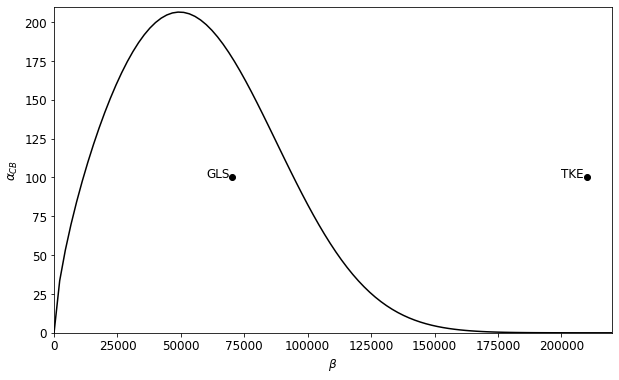

In [4]:
# Plot alpha_CB vs beta
fig, ax = plt.subplots(figsize=(10, 6))
beta = np.linspace(0, 2.2e5, 100)
cpu_star = (beta / 665)**(2/3)
alpha_CB = 15 * cpu_star * np.exp(-(0.04 * cpu_star)**4)
ax.plot(beta, alpha_CB, 'k-')
ax.plot([7e4, 2.1e5], [100, 100], 'ko')
ax.text(6e4, 100, 'GLS')
ax.text(2e5, 100, 'TKE')
ax.set_xlim([0, 2.2e5])
ax.set_ylim([0, 210])
ax.set_xlabel('$\\beta$')
ax.set_ylabel('$\\alpha_{CB}$')
plt.show()

Immediately we can see the GLS choice of $\beta$ is much closer the the wave age dependence summarized by Mellor and Blumberg than the TKE choice from Stacey.

In [5]:
def calc_Cd(wspd):
    """Calculate the surface drag coefficient according to
    Hellerman and Rosenstein (1983) JPO, neglecting T effects
    """
    
    # Coefficients
    a_1 = 0.934e-3
    a_2 = 0.788e-4
    a_3 = 0.868e-4
    a_4 = -0.616e-6
    a_5 = -0.120e-5
    a_6 = -0.214e-5

    # Neglect temperature gradient
    Delta_T = 0

    # Calc C_d
    C_d = a_1 + a_2 * wspd + a_3 * Delta_T + a_4 * wspd**2 + a_5 * Delta_T**2 + a_6 * wspd * Delta_T
    
    return C_d

In [66]:
startdate = datetime(2020, 1, 1)
slc = {'latitude': slice(160, 450), 'longitude': slice(120, 470)}
with xr.open_dataset(nc_tools.get_WW3_path(startdate)) as ds:
    mask = ds.MAPSTA.isel(slc).values.ravel().astype(bool)

Hs, cp, u2 = [], [], []
for day in tqdm(range(360)):
    fn = nc_tools.get_WW3_path(startdate + timedelta(days=day))
    with xr.open_dataset(fn).isel(slc) as ds:
        hs, lm, t02, u, v = [ds[var].values.reshape(48, -1)[:, mask].mean(axis=1) for var in ('hs', 'lm', 't02', 'uwnd', 'vwnd')]
        Hs.append(hs)
        cp.append(lm/t02)
        u2.append(u**2 + v**2)

  0%|          | 0/360 [00:00<?, ?it/s]

In [69]:
Hs = np.hstack(Hs)
cp = np.hstack(cp)
u2 = np.hstack(u2)

In [132]:
rho_ratio, g = 28, 9.81
ustar = np.sqrt(calc_Cd(np.sqrt(u2)) * u2)
index = ustar > 0

### Rascle et al. 2008 Ocean Modelling

$$H_s = kz_0 = \frac{\beta}{0.85}\frac{w_*^2}{g}$$

$$\beta \approx 665\left(\frac{c_p}{u_*}\right)^{1.5}$$

$$\frac{c_p}{u_*} = W_{max}\tanh \frac{2u_{*ref}}{u_*}$$

<ipython-input-142-b81768c4c95a>:3: RuntimeWarning: divide by zero encountered in true_divide
  _, _, _, c = axs[0].hist2d(ustar[index], (cp/ustar)[index], bins=100, range=[(0, 0.8), (0, 100)], norm=colors.LogNorm(vmin=1, vmax=40))
<ipython-input-142-b81768c4c95a>:6: RuntimeWarning: divide by zero encountered in true_divide
  waveage = coeff * np.tanh(2*ustar_ref/ustar_plot)
<ipython-input-142-b81768c4c95a>:6: RuntimeWarning: divide by zero encountered in true_divide
  waveage = coeff * np.tanh(2*ustar_ref/ustar_plot)
<ipython-input-142-b81768c4c95a>:6: RuntimeWarning: divide by zero encountered in true_divide
  waveage = coeff * np.tanh(2*ustar_ref/ustar_plot)


Text(0, 0.5, 'Significant wave height $H_s$ [m]')

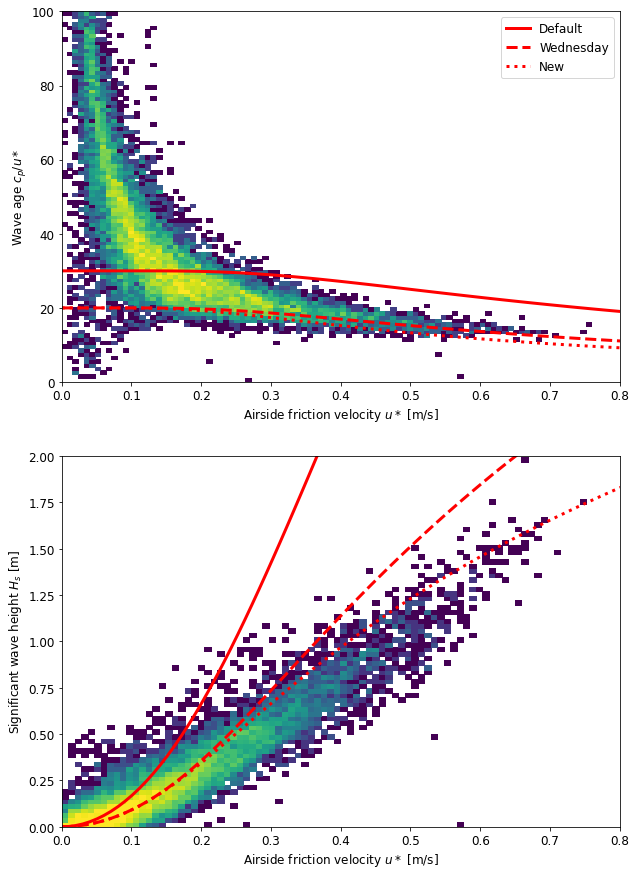

In [142]:
ustar_plot = np.linspace(0, 1, 100)
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
_, _, _, c = axs[0].hist2d(ustar[index], (cp/ustar)[index], bins=100, range=[(0, 0.8), (0, 100)], norm=colors.LogNorm(vmin=1, vmax=40))
_, _, _, c = axs[1].hist2d(ustar[index], Hs[index], bins=100, norm=colors.LogNorm(vmin=1, vmax=100))
for coeff, ustar_ref, ls, label in zip([30, 20, 20], [0.3, 0.25, 0.20], ['-', '--', ':'], ['Default', 'Wednesday', 'New']):
    waveage = coeff * np.tanh(2*ustar_ref/ustar_plot)
    beta = 665 * waveage**(1.5)
    swh = beta / 0.85 * (ustar_plot / rho_ratio)**2 / g
    axs[0].plot(ustar_plot, waveage, ls, color='r', lw=3, label=label)
    axs[1].plot(ustar_plot, swh, ls, color='r', lw=3)
axs[0].set_xlim([0, 0.8])
axs[0].set_ylim([0, 100])
axs[0].set_xlabel('Airside friction velocity $u*$ [m/s]')
axs[0].set_ylabel('Wave age $c_p/u*$')
axs[0].legend()
axs[1].set_xlim([0, 0.8])
axs[1].set_ylim([0, 2])
axs[1].set_xlabel('Airside friction velocity $u*$ [m/s]')
axs[1].set_ylabel('Significant wave height $H_s$ [m]')

In [65]:
for var in ds.variables:
    print(f'{ds[var].name:10s}', ds[var].long_name)

MAPSTA     status map
dir        wave mean direction
dp         peak direction
foc        wave to ocean energy flux
fp         wave peak frequency
hs         significant height of wind and swell waves
latitude   latitude
lm         mean wave length
longitude  longitude
t02        mean period T02
time       julian day (UT)
ucur       eastward current
utwo       eastward wave to ocean stress
uuss       eastward surface stokes drift
uwnd       eastward_wind
vcur       northward current
vtwo       northward wave to ocean stress
vuss       northward surface stokes drift
vwnd       northward_wind
wcc        whitecap coverage
wch        significant breaking wave height
